# Otter populations in california

Project 1

Gail Romer and Mellie Zito

In [10]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

from pandas import read_csv

In [11]:
filename = 'Otterdata.csv'
tables = read_csv(filename, header=0, index_col=0, decimal='M');

In [12]:
pup_total = tables.pups
otter_total = tables.total
mature_total = otter_total - pup_total;

Reads in a data table for otter pup and total otter populations. The number of pups is subtracted from the total to get the number of mature otters.

In [13]:
pofo = 0.4 #percentage of female otters
pomo = 1 - pofo 

female_pups = pup_total * pofo
male_pups = pup_total * pomo

f_mature = (otter_total - pup_total) * pofo
m_mature = (otter_total - pup_total) * pomo;

Based on at least two articles, there have been less female otters than male otters in recent years due to unknown factors. 
We break mature otters and pups into male and female and set male otters as a greater percentage of the population.

In [14]:
def plot_results(male, female, timeseries, title):
    """Plot the estimates and the model.
    
    male and female: TimeSeries of population estimates broken into male and female
    timeseries: TimeSeries of simulation results
    title: string
    """
    
    plot(female+male, ':', label='otters')
    
    
    plot(timeseries, "--", color='gray', label='model_otters')
    
    decorate(xlabel='Year', 
             ylabel='Otter Population',
             title=title)

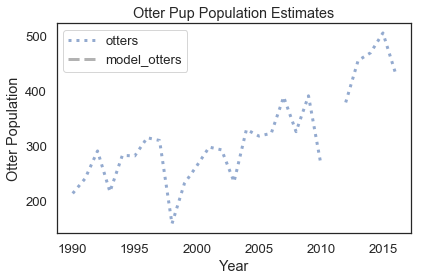

In [15]:
empty = TimeSeries()
plot_results(male_pups, female_pups,  empty, 'Otter Pup Population Estimates')

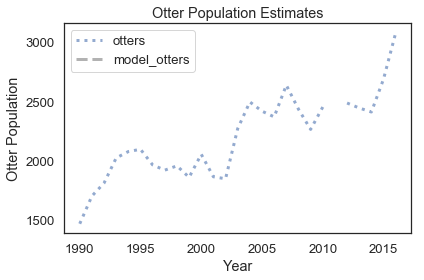

In [16]:
plot_results(f_mature, m_mature, empty, 'Otter Population Estimates')

The populations of otter pups and mature otters was plotted based on the data table

### What is the smallest number of female otters that can sustain the california otter population for the next 20 years?

Although otter populations are on the rise now, female otter populations are disproportionally affected and lower than male otter populations. If this disparity in female otters continues, it could affect birth rates, and potentially affect otter pup populations and then total otter populations. It's important to analyze what percentage of female otters dying off would cause otters to die in california, in order to maintain stable otter populations in California.

Old question: At what point of less female otters will birth rates be low enough that otter populations die out in the next 20 years in california?

In [17]:
'''State initialized with initial population numbers broken into groups'''

init_f_pups = get_first_value(female_pups)
init_m_pups = get_first_value(male_pups)
init_f_mature = get_first_value(f_mature)
init_m_mature = get_first_value(m_mature)

init_state = State(f_pups=init_f_pups, m_pups=init_m_pups, f_mature=init_f_mature, m_mature=init_m_mature)

,values
f_pups,85.6
m_pups,128.4
f_mature,586.4
m_mature,879.6


Birth rate per female is < 1 per year


             https://seaworld.org/animal-info/animal-infobooks/otters/birth-and-care-of-young                
                
Sea otter gestation range from four to nine months, with an average of six months.
Sea otters give birth throughout the year, with peaks in late May and June for Alaska otters, and March and September for California otters.
Sea otters are capable of giving birth every year, but females usually experience much longer birth intervals.
             https://www.biologicaldiversity.org/species/mammals/sea_otter/natural_history.html
                
                
Female otters reach sexual maturity at three years of age, and males follow at five to six years
Male sea otters live between 10 and 15 years, while females live slightly longer, from 15 to 20 years

In [18]:
f_birth_rate = .035
m_birth_rate = f_birth_rate 

maturation_rate = .16
f_death_rate = .0008 # female vs male death rate subject to change, possibly sweep
m_death_rate = .0008
t_0 = 1990
t_mid = 2015
t_end = 2035

'''Birth rates, maturation rate, and death rates are set and adjusted to fit data's trends
t_0, t_mid, and t_end are set based on the years the data covers and the "current year" (2015) 
to then make projections into the next 20 years
The initial state is also added to the system to then be modified for each time step
'''

system = System(f_birth_rate = f_birth_rate, #Lets figure out how birth rate relates to F pop
                m_birth_rate = m_birth_rate, #Lets figure out how birth rate relates to F pop
                maturation_rate = maturation_rate,
                f_death_rate = f_death_rate, # female vs male death rate subject to change, possibly sweep
                m_death_rate = m_death_rate, 
                t_0 = t_0,
                t_mid = t_mid,
                t_end = t_end,
                state = init_state,
                state_2 = init_state)

,values
f_birth_rate,0.035
m_birth_rate,0.035
maturation_rate,0.16
f_death_rate,0.0008
m_death_rate,0.0008
t_0,1990
t_mid,2015
t_end,2035
state,f_pups 85.6 m_pups 128.4 f_mature ...
state_2,f_pups 85.6 m_pups 128.4 f_mature ...


In [19]:
def update_func1(state, t, system):
    '''the initial populations from state and the rates from system are used to
    update the births, pups that become mature otters, the deaths, and the new populations.
    '''
    
    f_births = system.f_birth_rate * state.f_mature
    
    m_births = system.m_birth_rate * state.f_mature
    
    f_maturlings = system.maturation_rate * state.f_pups
    
    m_maturlings = system.maturation_rate * state.m_pups
        
    f_deaths = f_death_rate * state.f_mature
    
    m_deaths = system.m_death_rate * state.m_mature
    
    f_otters = state.f_mature - f_deaths + f_maturlings
    
    m_otters = state.m_mature - m_deaths + m_maturlings
    
    f_pups = state.f_pups + f_births - f_maturlings - system.m_death_rate
    
    m_pups = state.m_pups + m_births - m_maturlings - system.m_death_rate
    
    
    return State(f_pups=f_pups, m_pups=m_pups, f_mature=f_otters, m_mature=m_otters)

Update function 1 updates populations of the model for every year, based on system birth, maturation, and death rates. Update function 2 is the same as update function 1, except that it replaces the given static death rate for female otters with death_rate. death_rate is a changing value for female otter death rate from a sweepseries.

In [20]:
def update_func2(state, t, death_rate, system):
    '''the initial populations from state and the rates from system are used to
    update the births, pups that become mature otters, the deaths, and the new populations.
    '''
    
    f_births = system.f_birth_rate * state.f_mature
    
    m_births = system.m_birth_rate * state.f_mature
    
    f_maturlings = system.maturation_rate * state.f_pups
    
    m_maturlings = system.maturation_rate * state.m_pups
        
    f_deaths = death_rate * state.f_mature
    
    m_deaths = system.m_death_rate * state.m_mature
    
    f_otters = state.f_mature - f_deaths + f_maturlings
    
    m_otters = state.m_mature - m_deaths + m_maturlings
    
    f_pups = state.f_pups + f_births - f_maturlings - system.m_death_rate
    
    m_pups = state.m_pups + m_births - m_maturlings - system.m_death_rate
    
    
    return State(f_pups=f_pups, m_pups=m_pups, f_mature=f_otters, m_mature=m_otters)

In [21]:
def run_simulation1(system, update_func):
    """Simulate the system using any update function.
    
    state: initial State object
    system: System object
    update_func: function that computes the population next year
    
    returns: TimeSeries of mature otters and otter pups
    """
    results_mature = TimeSeries()
    results_pups = TimeSeries()
    
    state = system.state
    results_mature[system.t_0] = state.f_mature + state.m_mature
    results_pups[system.t_0] = state.f_pups + state.m_pups
    
    for t in linrange(system.t_0, system.t_mid):
        state = update_func(state, t, system)
        results_mature[t+1] = state.f_mature + state.m_mature
        results_pups[t+1] = state.f_pups + state.m_pups
    return results_mature, results_pups

Run simulation 1 uses update function to calculate new populations from the 1990 to 2015. Run simulation 2 is the same as run simulation 1, but predicts the population for 20 years past 2015, using t_0 = 1990, t_mid = 2015, and t_end = 2035. 

In [26]:
def run_simulation2(system, update_func):
    """Simulate the system using any update function.
    
    init: initial State object
    system: System object
    update_func: function that computes the population next year
    
    returns: TimeSeries of mature otters and otter pups
    """
    results_mature = TimeSeries()
    results_pups = TimeSeries()
    
    state = system.state
    results_mature[system.t_mid] = state.f_mature + state.m_mature
    results_pups[system.t_mid] = state.f_pups + state.m_pups
        
    for t in linrange(system.t_mid+1, system.t_end):
        state = update_func(state, t, death_rate, system)
        results_mature[t+1] = state.f_mature + state.m_mature
        results_pups[t+1] = state.f_pups + state.m_pups
    return results_mature, results_pups

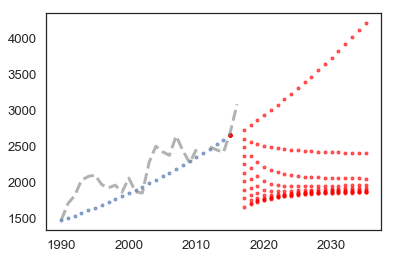

In [30]:
'''Results from run simulation 1 were used to fit the model to the data for the population between 1990 and 2015. 
Run simulation 2 is then used to create multiple models for the sweep of female otter death rates.
'''

results_mature1 = run_simulation1(system, update_func1)[0];
results_pups1 = run_simulation1(system, update_func1)[1];

mature_2015 = get_last_value(results_mature1) # Gets final value of results_mature1

pups_2015 = get_last_value(results_pups1) # Gets final value of results_pups1


state = State(f_pups = pofo * pups_2015, m_pups = pomo * pups_2015, f_mature = pofo * mature_2015, m_mature = pomo * mature_2015)

system_2 = System(f_birth_rate = f_birth_rate, #Lets figure out how birth rate relates to F pop
                m_birth_rate = m_birth_rate, #Lets figure out how birth rate relates to F pop
                maturation_rate = maturation_rate,
                f_death_rate = f_death_rate, # female vs male death rate subject to change, possibly sweep
                m_death_rate = m_death_rate, 
                t_0 = t_0,
                t_mid = t_mid,
                t_end = t_end,
                state = state)


plot(results_mature1, '.', label = 'otters')

death_rate_array = linspace(0, 1, 10) # Array for death rate sweep

sweep_pups = SweepSeries() # Array to hold swept pup data
sweep_mature = SweepSeries() # Array to hold swept mature data

for death_rate in death_rate_array: # Sweeping death rate
    results_mature = run_simulation2(system_2, update_func2)[0];
    results_pups = run_simulation2(system_2, update_func2)[1];

    sweep_pups = results_pups
    sweep_mature = results_mature #+ results_mature1
    
    empty = TimeSeries()
    
    plot(sweep_mature, '.', color = 'red', label = 'help')
#     plot(results_mature# + results_mature1
#          , ':', label='model otters')
    
    

plot(f_mature+m_mature, "--", color='gray', label='og otters')

    
